In [148]:
import numpy as np
import pandas as pd
from sklearn.utils import _pprint
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from sklearn.linear_model import LogisticRegression
import xgboost as xgb
from sklearn.metrics import plot_confusion_matrix
from imblearn.under_sampling import RandomUnderSampler
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import plot_roc_curve, roc_auc_score 
# display first 500 rows
# pd.set_option('display.max_rows',500)

# Loading Data

In [107]:
df_admi = pd.read_csv('./dataset/ADMISSIONS.csv')
df_diag = pd.read_csv('./dataset/DIAGNOSES_ICD.csv')
df_los = pd.read_csv('./dataset/ICUSTAYS.csv')
df_patient = pd.read_csv('./dataset/PATIENTS.csv')

#  Data Preparation

### Admissions Table

In [108]:
df_admi = df_admi.dropna()
df_admi = df_admi.drop_duplicates(subset=['SUBJECT_ID'],keep = 'first')
df_admi.drop([
    "ROW_ID",
    "ADMITTIME",
    "DISCHTIME",
    "DEATHTIME",
    "EDREGTIME",
    "EDOUTTIME",
    "HOSPITAL_EXPIRE_FLAG",
    "HAS_CHARTEVENTS_DATA",
    "DIAGNOSIS",
    "LANGUAGE",
    "HADM_ID"
], axis=1, inplace=True)
df_admi.head()

,SUBJECT_ID,ADMISSION_TYPE,ADMISSION_LOCATION,DISCHARGE_LOCATION,INSURANCE,RELIGION,MARITAL_STATUS,ETHNICITY
193,109,EMERGENCY,EMERGENCY ROOM ADMIT,DEAD/EXPIRED,Medicaid,NOT SPECIFIED,SINGLE,BLACK/AFRICAN AMERICAN
196,111,EMERGENCY,EMERGENCY ROOM ADMIT,DEAD/EXPIRED,Medicare,PROTESTANT QUAKER,MARRIED,WHITE
238,304,EMERGENCY,EMERGENCY ROOM ADMIT,DEAD/EXPIRED,Medicaid,CATHOLIC,WIDOWED,BLACK/AFRICAN AMERICAN
303,353,EMERGENCY,EMERGENCY ROOM ADMIT,DEAD/EXPIRED,Medicare,JEWISH,SINGLE,WHITE
358,502,EMERGENCY,CLINIC REFERRAL/PREMATURE,DEAD/EXPIRED,Private,PROTESTANT QUAKER,MARRIED,WHITE


## Diagnoses Table

In [109]:
# Diagnoses table
df_diag = df_diag.dropna()
df_diag.drop([
    "ROW_ID",
    "SEQ_NUM",
    "HADM_ID"
],axis = 1, inplace = True)
df_diag.loc[df_diag["ICD9_CODE"].str.contains('99591'),"ICD9_CODE"] = '\+1'
df_diag.loc[~df_diag["ICD9_CODE"].str.contains('\+1'),"ICD9_CODE"]= '\-1' 

def label_sepsis (e):
    if e in '\+1':
        return 1
    else:
        return 0
    
df_diag['is_sepsis'] = df_diag['ICD9_CODE'].apply(lambda e :label_sepsis(e))

df_diag.drop([
    "ICD9_CODE",
],axis = 1, inplace = True)
df_diag = df_diag.sort_values('is_sepsis')
df_diag = df_diag.drop_duplicates(subset = 'SUBJECT_ID', keep = "last")
df_diag.head()

,SUBJECT_ID,is_sepsis
433800,50480,0
433832,50484,0
433714,50359,0
433745,50361,0
433753,50362,0


### LOS Table

In [110]:
df_los = df_los.dropna()
df_los = df_los.groupby('SUBJECT_ID').mean().reset_index()
df_los.drop([
    "ROW_ID",
    "ICUSTAY_ID",
    "FIRST_WARDID",
    "LAST_WARDID",
    "HADM_ID"
],axis = 1, inplace = True)

df_los.LOS = df_los.LOS.astype(int)
df_los = df_los.loc[df_los['LOS']>=1]
df_los.head()

,SUBJECT_ID,LOS
1,3,6
2,4,1
4,6,3
6,8,1
7,9,5


### Patient Table

In [111]:
df_patient = df_patient.dropna()
df_patient['DOB'] = pd.to_datetime(df_patient['DOB']).dt.date
df_patient['DOD'] = pd.to_datetime(df_patient['DOD']).dt.date
df_patient['age'] = df_patient.apply(lambda e:(e['DOD'] - e['DOB']).days/365,axis = 1)
df_patient.age = df_patient.age.astype(int)
df_patient.drop([
    "ROW_ID",
    "EXPIRE_FLAG",
    "DOD_SSN",
    "DOD_HOSP",
    "DOD",
    "DOB"
],axis = 1, inplace = True)
df_patient = df_patient.loc[df_patient['age']<=100]
df_patient.head()

,SUBJECT_ID,GENDER,age
7,257,F,90
10,261,M,76
25,668,F,86
26,669,M,60
27,670,M,80


### Merge Tables

In [112]:
df_merge = pd.merge(df_admi, df_diag, on="SUBJECT_ID")
df_merge = pd.merge(df_merge,df_los, on="SUBJECT_ID")
df_merge = pd.merge(df_merge,df_patient, on="SUBJECT_ID")
df_merge.drop([
    "SUBJECT_ID",
    "ADMISSION_TYPE",
    "DISCHARGE_LOCATION"
],axis = 1, inplace = True)

# downcasting int64 to int 32
d = dict.fromkeys(df_merge.select_dtypes(np.int64).columns, np.int32)
df_merge = df_merge.astype(d)
# df_merge.dtypes
df_merge.head()

,ADMISSION_LOCATION,INSURANCE,RELIGION,MARITAL_STATUS,ETHNICITY,is_sepsis,LOS,GENDER,age
0,EMERGENCY ROOM ADMIT,Medicaid,NOT SPECIFIED,SINGLE,BLACK/AFRICAN AMERICAN,0,2,F,25
1,EMERGENCY ROOM ADMIT,Medicare,JEWISH,SINGLE,WHITE,1,2,M,63
2,CLINIC REFERRAL/PREMATURE,Private,PROTESTANT QUAKER,MARRIED,WHITE,0,6,M,50
3,EMERGENCY ROOM ADMIT,Private,CATHOLIC,MARRIED,WHITE,0,3,M,56
4,CLINIC REFERRAL/PREMATURE,Private,CATHOLIC,MARRIED,WHITE,0,3,M,56


# Perpering Train/Test Data

In [113]:
# Indepenet variable
X = df_merge.drop('is_sepsis',axis = 1).copy()
X.head()

,ADMISSION_LOCATION,INSURANCE,RELIGION,MARITAL_STATUS,ETHNICITY,LOS,GENDER,age
0,EMERGENCY ROOM ADMIT,Medicaid,NOT SPECIFIED,SINGLE,BLACK/AFRICAN AMERICAN,2,F,25
1,EMERGENCY ROOM ADMIT,Medicare,JEWISH,SINGLE,WHITE,2,M,63
2,CLINIC REFERRAL/PREMATURE,Private,PROTESTANT QUAKER,MARRIED,WHITE,6,M,50
3,EMERGENCY ROOM ADMIT,Private,CATHOLIC,MARRIED,WHITE,3,M,56
4,CLINIC REFERRAL/PREMATURE,Private,CATHOLIC,MARRIED,WHITE,3,M,56


In [114]:
# Dependent variable
y = df_merge['is_sepsis'].copy()
y.head()
y.unique

<bound method Series.unique of 0       0
1       1
2       0
3       0
4       0
       ..
1058    0
1059    0
1060    0
1061    0
1062    0
Name: is_sepsis, Length: 1063, dtype: int32>

In [115]:
# Data transformation --> one hot encoding
X_encoded = pd.get_dummies(X, columns=[
    'ADMISSION_LOCATION',
    'INSURANCE',
    'RELIGION',
    'MARITAL_STATUS',
    'ETHNICITY',
    'GENDER'
])
X_encoded.head()


,LOS,age,ADMISSION_LOCATION_CLINIC REFERRAL/PREMATURE,ADMISSION_LOCATION_EMERGENCY ROOM ADMIT,ADMISSION_LOCATION_PHYS REFERRAL/NORMAL DELI,ADMISSION_LOCATION_TRANSFER FROM HOSP/EXTRAM,ADMISSION_LOCATION_TRANSFER FROM OTHER HEALT,ADMISSION_LOCATION_TRANSFER FROM SKILLED NUR,INSURANCE_Government,INSURANCE_Medicaid,...,ETHNICITY_PATIENT DECLINED TO ANSWER,ETHNICITY_PORTUGUESE,ETHNICITY_UNABLE TO OBTAIN,ETHNICITY_UNKNOWN/NOT SPECIFIED,ETHNICITY_WHITE,ETHNICITY_WHITE - EASTERN EUROPEAN,ETHNICITY_WHITE - OTHER EUROPEAN,ETHNICITY_WHITE - RUSSIAN,GENDER_F,GENDER_M
0,2,25,0,1,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,1,0
1,2,63,0,1,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,1
2,6,50,1,0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,1
3,3,56,0,1,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,1
4,3,56,1,0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,1


<AxesSubplot:ylabel='is_sepsis'>

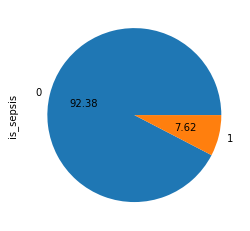

In [116]:
# Display pie chart
y.value_counts().plot.pie(autopct='%.2f')

Dataset is unbalanced

### Random Undersampling

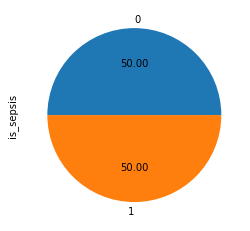

In [117]:
rus = RandomUnderSampler(sampling_strategy=1)
X_res, y_res = rus.fit_resample(X_encoded, y)

ax = y_res.value_counts().plot.pie(autopct='%.2f')

In [118]:
X_train, X_test, y_train, y_test = train_test_split(X_res, y_res, random_state = 42, test_size=0.2)


In [119]:
sum(y_train)/len(y_train)

0.5038759689922481

In [120]:
sum(y_test)/len(y_test)

0.48484848484848486

## XGBoost

### Training Model

In [121]:
# Fitting models
clf_xgb = xgb.XGBClassifier(
    objective='binary:logistic',
    n_estimators = 5000,
    missing = 1, 
    seed = 42,
    use_label_encoder = False,
    eval_metric='auc',
    verbosity = 1
)

clf_xgb.fit(X_train,
            y_train,
            verbose=True,
            early_stopping_rounds=10,
            eval_set=[(X_test, y_test)]
)

[0]	validation_0-auc:0.61581
[1]	validation_0-auc:0.61029
[2]	validation_0-auc:0.62316
[3]	validation_0-auc:0.57904
[4]	validation_0-auc:0.56434
[5]	validation_0-auc:0.53493
[6]	validation_0-auc:0.52757
[7]	validation_0-auc:0.53309
[8]	validation_0-auc:0.52941
[9]	validation_0-auc:0.53677
[10]	validation_0-auc:0.50735
[11]	validation_0-auc:0.52206


/home/alexzeng/anaconda3/envs/sepsis-project/lib/python3.9/site-packages/xgboost/data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, enable_categorical=False,
              eval_metric='auc', gamma=0, gpu_id=-1, importance_type=None,
              interaction_constraints='', learning_rate=0.300000012,
              max_delta_step=0, max_depth=6, min_child_weight=1, missing=1,
              monotone_constraints='()', n_estimators=5000, n_jobs=8,
              num_parallel_tree=1, predictor='auto', random_state=42,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=42,
              subsample=1, tree_method='exact', use_label_encoder=False,
              validate_parameters=1, ...)

### Ploting Confusion Matrix

/home/alexzeng/anaconda3/envs/sepsis-project/lib/python3.9/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


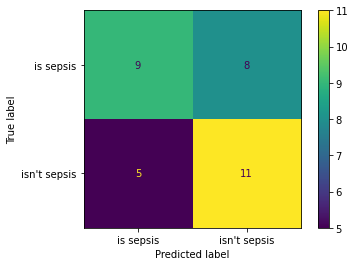

In [122]:
# Model Performance
plot_confusion_matrix(clf_xgb,
                     X_test,
                     y_test,
                     values_format='d',
                     display_labels=["is sepsis","isn't sepsis"])
                     

## Logistic Regression

### Training Model

In [127]:
clf_lr = LogisticRegression(solver='lbfgs', max_iter=400)

clf_lr.fit(X_train, y_train)

LogisticRegression(max_iter=400)

### Ploting Confusion Matrix

/home/alexzeng/anaconda3/envs/sepsis-project/lib/python3.9/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


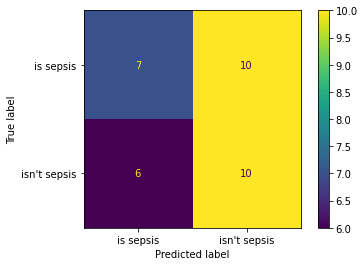

In [128]:
# Model Performance
plot_confusion_matrix(clf_lr,
                     X_test,
                     y_test,
                     values_format='d',
                     display_labels=["is sepsis","isn't sepsis"])
                     

## Random Forest

### Training Model

In [130]:
clf_rf = RandomForestClassifier()
clf_rf.fit(X_train, y_train)


RandomForestClassifier()

### Ploting Confusion Matrix

/home/alexzeng/anaconda3/envs/sepsis-project/lib/python3.9/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


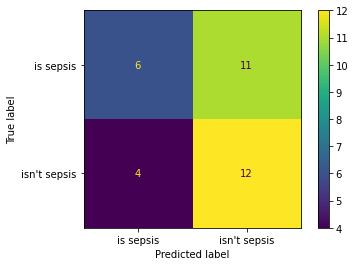

In [131]:
# Model Performance
plot_confusion_matrix(clf_rf,
                     X_test,
                     y_test,
                     values_format='d',
                     display_labels=["is sepsis","isn't sepsis"])


# Model Comparison

In [142]:
xgb_probs = clf_xgb.predict_proba(X_test)
lr_probs = clf_lr.predict_proba(X_test)
rf_probs = clf_rf.predict_proba(X_test)

In [143]:
xgb_probs = xgb_probs[:, 1]
lr_probs = lr_probs [:, 1]
rf_probs = rf_probs [:, 1]

In [144]:
xgb_probs = roc_auc_score(y_test, xgb_probs)
lr_probs = roc_auc_score(y_test,lr_probs )
rf_probs = roc_auc_score(y_test,rf_probs )

### Calculate ROC Score

In [147]:
print('XGBoost: AUROC = %.3f' %(xgb_probs))
print('Logistic Regression: AUROC = %.3f' %(lr_probs))
print('Random Forest: AUROC = %.3f' %(rf_probs))

XGBoost: AUROC = 0.623
Logistic Regression: AUROC = 0.460
Random Forest: AUROC = 0.588


(33,)

### Plot Calculate ROC Curve

/home/alexzeng/anaconda3/envs/sepsis-project/lib/python3.9/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_roc_curve is deprecated; Function `plot_roc_curve` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: RocCurveDisplay.from_predictions or RocCurveDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)
/home/alexzeng/anaconda3/envs/sepsis-project/lib/python3.9/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_roc_curve is deprecated; Function `plot_roc_curve` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: RocCurveDisplay.from_predictions or RocCurveDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)
/home/alexzeng/anaconda3/envs/sepsis-project/lib/python3.9/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_roc_curve is deprecated; Function `plot_roc_curve` is deprecated in 1.0 and will be removed in 1.2. Use one o

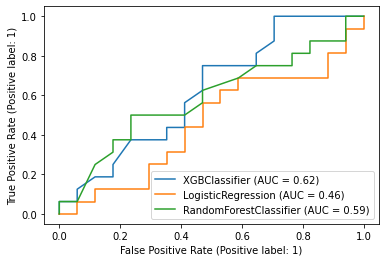

In [149]:
disp = plot_roc_curve(clf_xgb, X_test, y_test)
plot_roc_curve(clf_lr, X_test, y_test, ax=disp.ax_)
plot_roc_curve(clf_rf, X_test, y_test, ax=disp.ax_)